# Exploring the UK Food Hygiene ratings scheme (Part 1)

The inspiration for this project stemmed from my love for food and coffee and my ongoing quest to explore all the caf&eacute;s around Birmingham and see what they have to offer. Almost always, I use google to get this information and look for all the cafe&acute;s around me with their locations as well as reviews, ratings and photos shared by people.

When I first came to the UK from India (8 years ago) I saw some rating signs in front of places which served food and I did not know at the time what they meant. These look something like: ![Logo](http://ratings.food.gov.uk/images/OpenData/fhrs5.jpg)
To the uninformed me at the time the ratings from 1-5 could have meant anything from the overall ambience/experience of the place to the customer service or the culinary experience to the food quality I could expect there. I went up close to one of the signs to read what it said and 'no longer was I an uninformed'. The mysterious numbers had a meaning!. They depicted the hyegene standards of the place that was serving food to the public. That was awesome! As far as I was aware at the time, back in India there was no such system in place for the public to 'clearly see' the hygiene rating for an establishment. 

I also found that unfortunatley not all places have these signs up on their premises in England. I learned that it is only good practice to do so in England while it is compulsory to display them in Wales and Northern Ireland. Scotland has its own food hyegene scheme with a different rating system and once again it is only voluntary to display them. But all places get a rating (unless they are exempt) and these are available to view online. However, this information was not directly available in my google search results. 

So recently when I started my hunt for the best coffee place in Birmingham with a friend of mine, it occured to me that it would be a cool project to be able to play with some data that could give me information about all cafe&acute;s and their ratings. If I could get hold of that data then I had an idea of using some plotting tools and creating some interactive visualisations of the places on a map using a python library I had been meaning to try out. This way I could get to play with some new tools that I had not used before and get an oppurtunity to learn something new. 

The first thing I needed was to get a hold of some data so that I could get started. It turns out that UK Food Hygiene rating scheme (FHRS) provides data about all the establishments which are required by law to get a rating. This seemed like the perfect dataset which could get me ratings of all establishments and I started by delving into it. 



#### Importing the relevant modules

In [1]:
import requests
import pandas as pd
import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')

All information about the data can be found on [http://ratings.food.gov.uk/]. There are two ways in which the data can be obtained. The FHRS publishes the data for each participating local authorities in the UK, either as downloadable XML files or via their api which returns data as XML or json. I had to make a choice here between suing the prepared files or querieng the api and decided to investigate the api in the first instance. 

One way to possibly get the links to the files is to scrape the page and figure out the links and then use the requests module to get the data. I refrained from doing any scraping as I found that these links were returned from one of the api endpoints. So, for anyone wishing to get the prepared XML files, just check the code below for the api which returns these links. The FHRS api is located at [http://api.ratings.food.gov.uk/](http://api.ratings.food.gov.uk/). 

I began by investigating the api endpoint index located at (http://api.ratings.food.gov.uk/help)[http://api.ratings.food.gov.uk/help] and went through each endpoint. I was going to use the python requests package to make any http/s requests, and since json support is built in the requests package I decided to accept json data. Also since I was going to hit the same host multiple times during this investigation I learned that it is a good idea to use a request session. This is becuase a session reuses the same TCP connection resulting in performance increase along with the additional benefit of the ability to provide default data to request methods. I think this (performance increase) is a bit overkill/insignificant for the purpose of this data analysis, but it was something new I learned (which could be useful in the future) and decided to try it out.

In [3]:
fhrs_session = requests.Session()
url_base = 'http://api.ratings.food.gov.uk/'
headers = {'x-api-version' : '2' , 'accept' : 'application/json'}

Using the created session I started to investigate the results from each endpoint. Some of the endpoints were not interesting for this project and I ignored those. My overall objective here was to download data for all the countries and create a single dataframe of the data so that all I needed to do in order to answer my questions and investigate, is to manipulate and visualise data from one source.

### Enpoint 1: Countries 

In [4]:
raw_countries = fhrs_session.get(url_base + 'Countries', headers = headers)

In [5]:
countries = pd.DataFrame.from_dict(raw_countries.json()['countries'])

In [6]:
countries.drop('links', axis=1, inplace=True)
countries

code  id              name           nameKey
0        1           England           England
1        2  Northern Ireland  Northern Ireland
2        3          Scotland          Scotland
3        4             Wales             Wales

This endpoint returns a table of all the countries along with some keys. 

### Endpoint 2: Ratings

In [7]:
raw_ratings = fhrs_session.get(url_base + 'Ratings', headers=headers)

In [8]:
ratings = pd.DataFrame.from_dict(raw_ratings.json()['ratings'])

In [9]:
ratings.drop(['links', 'ratingKey'], axis=1, inplace=True)

In [10]:
ratings

ratingId        ratingKeyName            ratingName  schemeTypeId
0         12                    5                     5             1
1         11                    4                     4             1
2         10                    3                     3             1
3          9                    2                     2             1
4          8                    1                     1             1
5          7                    0                     0             1
6          6                 Pass                  Pass             2
7          4  ImprovementRequired  Improvement Required             2
8          2  AwaitingPublication  Awaiting Publication             2
9          1   AwaitingInspection   Awaiting Inspection             2
10         3               Exempt                Exempt             2

This endpoint returns all the different rating values which can be assigned to an establishment along with some identifiers.  

### Endpoint 3: Business Types

In [12]:
raw_businesstypes = fhrs_session.get(url_base + 'BusinessTypes/Basic', headers=headers)

In [13]:
businesstypes = pd.DataFrame.from_dict(raw_businesstypes.json()['businessTypes']).drop('links', axis=1)

In [14]:
businesstypes

BusinessTypeId                       BusinessTypeName
0               -1                                    All
1                7              Distributors/Transporters
2             7838                        Farmers/growers
3                5    Hospitals/Childcare/Caring Premises
4             7842      Hotel/bed & breakfast/guest house
5               14                    Importers/Exporters
6             7839                  Manufacturers/packers
7             7846                         Mobile caterer
8             7841                Other catering premises
9             7843                      Pub/bar/nightclub
10               1                Restaurant/Cafe/Canteen
11            4613                      Retailers - other
12            7840  Retailers - supermarkets/hypermarkets
13            7845              School/college/university
14            7844                 Takeaway/sandwich shop

This is a table containing the different classes of businesses which are supposed to get an FHRS rating. It is here that I first found that 'Restaurant/Cafe/Canteen' were grouped into one category. It was a bit disheartening as I could not get information about caf&eacute;s as a separate business type therefore I could not in some sense find what I was after (separate ratings for caf&eacute;s). This is true in a lot of data-science projects where the business demands are hard to fulfill due to data limitations. Often in these scenarios we need to figure out if we can achieve something similar and acceptable that adds the original envisioned value to the business and fulfills the business needs or we give up as no possible solution can be found. In my case I decided to push through by justifying that caf&eacute;s and restuarants are clubbed together and since both are of interest to me personally I was OK in the first instance to see what insights I can find about them. At the same time I also knew that I could not do the same analysis limited to caf&eacute;s with this data and in order to do that I will have to extend this with some other data source in the future. This formed my motivation to continue with my analysis.

### Endpoint 4: Regions 

In [15]:
raw_regions = fhrs_session.get(url_base + 'Regions', headers=headers)

In [17]:
regions = pd.DataFrame.from_dict(raw_regions.json()['regions']).drop('links', axis=1)

In [18]:
regions

code  id                      name                   nameKey
0     E   1             East Counties             East Counties
1    EM   2             East Midlands             East Midlands
2   LDN   3                    London                    London
3    NE   4                North East                North East
4    NW   5                North West                North West
5    SE   6                South East                South East
6    SW   7                South West                South West
7    WM   8             West Midlands             West Midlands
8    YH   9  Yorkshire and Humberside  Yorkshire and Humberside
9    NI  10          Northern Ireland          Northern Ireland
10   SC  11                  Scotland                  Scotland
11   WA  12                     Wales                     Wales

This endpoint returns a table which contains region names. It turns out that separate region names are used for the regions for England while the regions of Northeren Ireland, Wales and Scotland are not present. I could only assume that this is perhaps due to the number of total businesses in each country and this is something I would like to check. 

In [19]:
def f(name):
    if name in ['Scotland','Wales', 'Northern Ireland']:
        return name
    else:
        return 'England'
    
    
regions['countries'] = regions['name'].apply(f)

In [25]:
regions

code  id                      name                   nameKey  \
0     E   1             East Counties             East Counties   
1    EM   2             East Midlands             East Midlands   
2   LDN   3                    London                    London   
3    NE   4                North East                North East   
4    NW   5                North West                North West   
5    SE   6                South East                South East   
6    SW   7                South West                South West   
7    WM   8             West Midlands             West Midlands   
8    YH   9  Yorkshire and Humberside  Yorkshire and Humberside   
9    NI  10          Northern Ireland          Northern Ireland   
10   SC  11                  Scotland                  Scotland   
11   WA  12                     Wales                     Wales   

           countries  
0            England  
1            England  
2            England  
3            England  
4            England  
5            England  
6            England  
7            England  
8            England  
9   Northern Ireland  
10          Scotland  
11             Wales

### Endpoint 5: Authorities

In [21]:
raw_authorities = fhrs_session.get(url_base + 'Authorities', headers=headers)

In [22]:
authorities = pd.DataFrame.from_dict(raw_authorities.json()['authorities']).drop(['links', 'Url', 'SchemeUrl','SchemeType', 'CreationDate', 'FileNameWelsh', 'FriendlyName'], axis=1)

Here I got a table returning the different authorities within the regions along with their details. It is here that I found the column 'FileName' which contained the links to the XML files containing the data about the businesses within each authority. Just to make things a little easier I merged the regions table with the authorities table to have new column which would link the authority to the region it was in.

In [23]:
authorities_with_regions = pd.merge(authorities, regions, left_on='RegionName', right_on='name')

In [24]:
authorities_with_regions.sort_values('EstablishmentCount').head()

Email  EstablishmentCount  \
388  port.health@redcar-cleveland.gov.uk                   7   
298         admin@hullandgoolepha.gov.uk                   9   
324    environmentalhealth@scilly.gov.uk                 108   
22              env.health@orkney.gov.uk                 320   
26            foodsafety@shetland.gov.uk                 346   

                                              FileName  \
388  http://ratings.food.gov.uk/OpenDataFiles/FHRS6...   
298  http://ratings.food.gov.uk/OpenDataFiles/FHRS6...   
324  http://ratings.food.gov.uk/OpenDataFiles/FHRS3...   
22   http://ratings.food.gov.uk/OpenDataFiles/FHRS7...   
26   http://ratings.food.gov.uk/OpenDataFiles/FHRS7...   

           LastPublishedDate  LocalAuthorityId LocalAuthorityIdCode  \
388   2018-09-05T08:20:01.13               408                  648   
298   2018-10-06T00:34:40.42               409                  626   
324  2018-10-02T00:32:40.413               321                  336   
22   2018-09-05T08:08:47.933               222                  785   
26    2018-10-06T00:32:29.81               226                  789   

                    Name                RegionName code  id  \
388           River Tees                North East   NE   4   
298  Hull and Goole Port  Yorkshire and Humberside   YH   9   
324      Isles of Scilly                South West   SW   7   
22        Orkney Islands                  Scotland   SC  11   
26      Shetland Islands                  Scotland   SC  11   

                         name                   nameKey countries  
388                North East                North East   England  
298  Yorkshire and Humberside  Yorkshire and Humberside   England  
324                South West                South West   England  
22                   Scotland                  Scotland  Scotland  
26                   Scotland                  Scotland  Scotland

In [26]:
a = authorities_with_regions.loc[324, 'LocalAuthorityId']
b = businesstypes.loc[businesstypes['BusinessTypeName'] == 'Restaurant/Cafe/Canteen', 'BusinessTypeId']
b[10]

1

In [23]:
# The following code will write to disk the XML file for each authority. I chose to not do this and go down via the json api route.
# This is provided here for anyone who would want to get the xml prepared data.
for file in merged_authorities['FileName']:
    print(file)
    xml_data=requests.get(file)    
    with open("dummy.xml", 'w') as fil:
        file.write(xml_data.text)

http://ratings.food.gov.uk/OpenDataFiles/FHRS760en-GB.xml


### Endpoint 6: Establishments


This end point supports multiple parameters allowing for fine grained searching. The possible parameters are listed on the api help page. I decided to query all the businesses of type=1 (Restaurants/Cafe/Canteens) and decided to get that data for each local authority. Essentially a subset of the data contained in the individual XML files, which contains information about all business categories. Please note this step can take a couple of minutes and I would strongly advice anyone reading this who wishes to try this out to be mindful of hitting the fhrs servers 'too hard'.

In [143]:
for auth_id in authorities_with_regions['LocalAuthorityId']:
    l = []
    payload  =  { 'localAuthorityId' : auth_id, 'businessTypeId' : str(b[10])}
    temp = fhrs_session.get(url_base + 'Establishments', params=payload, headers=headers).url
    l.append(temp)  

I was now interested to find out the distribution of the establishments of different ratings in all the countries, as well as their distribution in all of the regions considered.

In [36]:
countryframes = []
for countryid in countries.id:
    print(countryid)
    payload  =  {  'businessTypeId' : str(b[10]), 'countryId' : countryid}
    temp = fhrs_session.get(url_base + 'Establishments', params=payload, headers=headers)
    print(temp)
    countryframes.append(pd.DataFrame.from_dict(temp.json()['establishments']))

1
<Response [200]>
2
<Response [200]>
3
<Response [200]>
4
<Response [200]>


In [37]:
print(countryframes[0].shape, countryframes[1].shape, countryframes[2].shape, countryframes[3].shape)

(5000, 26) (3480, 26) (5000, 26) (5000, 26)


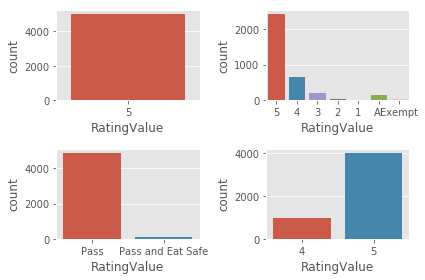

In [53]:
fig, axs = plt.subplots(ncols=2, nrows=2)
for i, ax in enumerate(axs.flat):
    sns.countplot(x=countryframes[i].RatingValue, data=countryframes[i], ax=ax )
plt.tight_layout()

These graphs look really wierd as surely England has establishments with ratings lower than 5 and most definitely the total number of places is over 5000. That got me wondering what was going on? Something wierd was happening, as for the countries with id 0, 2 and 3 only 5000 total establishement were returned. Going back to the api I saw that there is a system cap on the maximum number of results returned in this endpoing (paging), which makes sense. I needed a new way to fix this. Since I wanted to do similar plots for each region perhaps I could get data for each region and then merge the frames. Unfortunately, region was not one of the supported parameter for the payload. The closest I can get is get data for each local authority and then merge the frames to have a comprehensive dataframe. I could then use some dataframe manipulation tricks to get data for each region and also for each country and ten plot the counts. 

In [55]:
countryframe = {}
regionframes = {}
for country in countries.name:    
    for region in authorities_with_regions[authorities_with_regions.countries == country].RegionName.unique():        
        print(region)
        authorityframes = []
        for uthority in authorities_with_regions[authorities_with_regions.RegionName == region ].LocalAuthorityId:            
            payload  =  {'businessTypeId' : str(b[10]), 'localAuthorityId' : authority}
            temp = fhrs_session.get(url_base + 'Establishments', params=payload, headers=headers)            
            authorityframes.append(pd.DataFrame.from_dict(temp.json()['establishments']))
        regionframes[region] = pd.concat(authorityframes)
    countryframe[country] = pd.concat([regionframes[region] for region in authorities_with_regions[authorities_with_regions.countries == country].RegionName.unique()])

South East
North West
East Midlands
East Counties
London
Yorkshire and Humberside
South West
West Midlands
North East
Northern Ireland
Scotland
Wales


Since I had to make serveral api calls for each authority, I decided it is best to do this only once. Once again, please take care when hitting the servers and be considerate. If you are not short of time perhaps even add a small time delay between each call. This is a service provided free of cost to us and should not be misused. I saved the downloaded data into csv files which meant that I could make changes to the data and if I made a mistake then I could quickly load up the data from my saved files.

In [56]:
for key in regionframes.keys():
    regionframes[key].to_csv(key)
    
for country in countryframe.keys():
    countryframe[country].to_csv(country)

In [57]:
countryframe.keys()

dict_keys(['England', 'Northern Ireland', 'Scotland', 'Wales'])

In [58]:
regionframes['Wales'].RatingValue.unique()
for key in regionframes.keys():
    regionframes[key][regionframes[key]['RatingValue'] == 'AwaitingInspection'] = 'AI'
    regionframes[key][regionframes[key]['RatingValue'] == 'Awaiting Inspection'] = 'AI'
    regionframes[key][regionframes[key]['RatingValue'] == 'Exempt'] = 'E'    
    regionframes[key][regionframes[key]['RatingValue'] == 'AwaitingPublication'] = 'AP'    
    regionframes[key][regionframes[key]['RatingValue'] == 'Improvement Required'] = 'IR'
    regionframes[key][regionframes[key]['RatingValue'] == 'Pass and Eat Safe'] = 'AI'
    

In [59]:
unwanted_keys = ['Northern Ireland', 'Scotland', 'Wales']


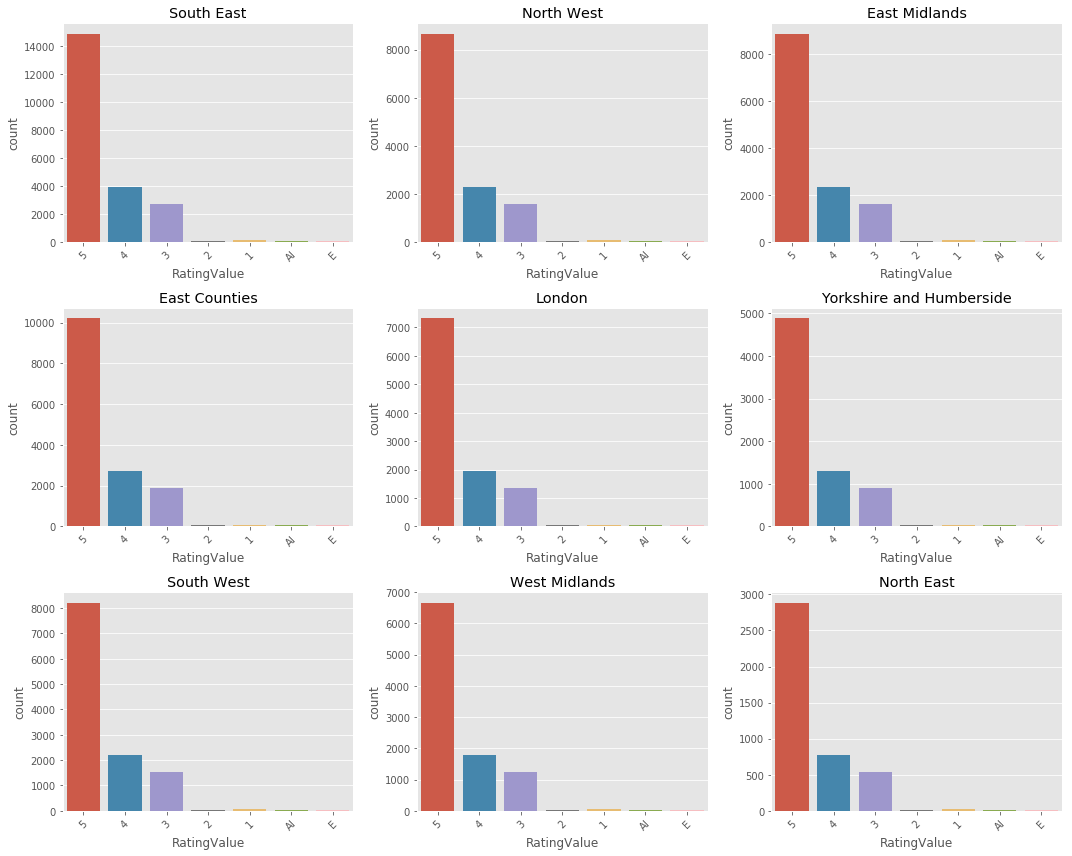

In [60]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,12))
for ax, reg in (zip(axs.flat, dict((k, [k]) for k in regionframes if k not in unwanted_keys).keys())):    
    sns.countplot(x=regionframes[reg].RatingValue, data=regionframes[reg], ax=ax )
    ax.set_title(reg)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()

Next I looked at the plots for the different countries. 

In [61]:
for key in countryframe.keys():
    countryframe[key][countryframe[key]['RatingValue'] == 'AwaitingInspection'] = 'AI'
    countryframe[key][countryframe[key]['RatingValue'] == 'Awaiting Inspection'] = 'AI'
    countryframe[key][countryframe[key]['RatingValue'] == 'Exempt'] = 'E'    
    countryframe[key][countryframe[key]['RatingValue'] == 'AwaitingPublication'] = 'AP'    
    countryframe[key][countryframe[key]['RatingValue'] == 'Improvement Required'] = 'IR'
    countryframe[key][countryframe[key]['RatingValue'] == 'Pass and Eat Safe'] = 'AI'

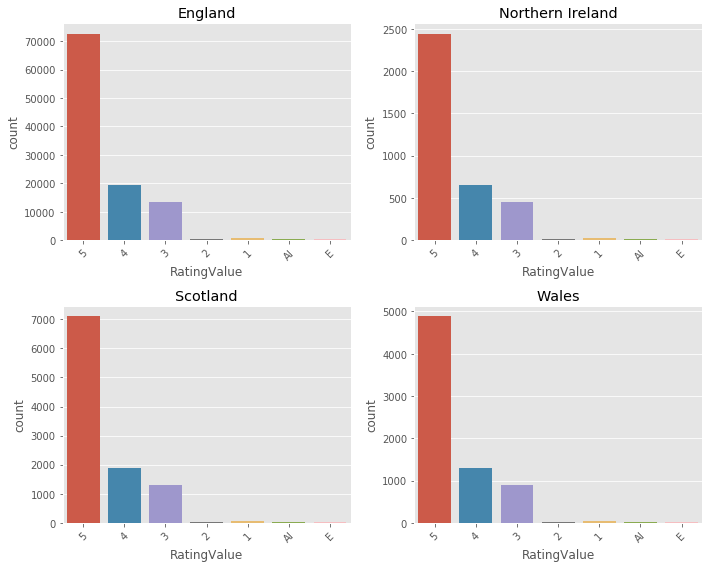

In [62]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
for ax, reg in (zip(axs.flat, countryframe.keys())):    
    sns.countplot(x=countryframe[reg].RatingValue, data=countryframe[reg], ax=ax )
    ax.set_title(reg)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()

Next, I decided to look into the data from one particular local authority. I decided upon the Isles of Scilly as it was a small set of data with only 25 businesses. The dataframe contained 26 columns of data for each business. I decided to have a look into the columns to see if I needed all of them. As it turned out I could drop around 12 columns from the table which were not interesting for this project. 

In [87]:
# Find scilly in authorities
scilly = authorities_with_regions.loc[authorities_with_regions.Name == 'Isles of Scilly']['LocalAuthorityId']

In [70]:
payload  =  { 'localAuthorityId' : str(scilly.values[0]), 'businessTypeId' : str(b[10])}

In [71]:
raw_establishments_scilly = fhrs_session.get(url_base + 'Establishments', params=payload, headers=headers)

In [73]:
print(raw_establishments_scilly.url)

http://api.ratings.food.gov.uk/Establishments?localAuthorityId=321&businessTypeId=1


In [91]:
scilly_frame = pd.DataFrame.from_dict(raw_establishments_scilly.json()['establishments'])

In [97]:
scilly_frame.head()

AddressLine1       AddressLine2     AddressLine3  \
0            Adam's Fish & Chips        Higher Town      St Martin's   
1              Terminal Building  St Mary's Airport  High Cross Lane   
2  Carn Vean Cafe And Guesthouse       Mount Todden        St Mary's   
3                          Downs           St Agnes  Isles Of Scilly   
4                 Covean Cottage        Higher Town         St Agnes   

      AddressLine4               BusinessName             BusinessType  \
0  Isles Of Scilly         Adams Fish & Chips  Restaurant/Cafe/Canteen   
1         Old Town               Airport Cafe  Restaurant/Cafe/Canteen   
2  Isles Of Scilly         Carn Vean Tearooms  Restaurant/Cafe/Canteen   
3                            Coastguards Cafe  Restaurant/Cafe/Canteen   
4  Isles Of Scilly  Covean B&B And Tea Garden  Restaurant/Cafe/Canteen   

   BusinessTypeID LocalAuthorityName  PostCode           RatingDate  \
0               1    Isles of Scilly            2017-05-09T00:00:00   
1               1    Isles of Scilly  TR21 0NG  2015-12-04T00:00:00   
2               1    Isles of Scilly  TR21 0NX  2018-09-12T00:00:00   
3               1    Isles of Scilly  TR22 0PL  2018-04-27T00:00:00   
4               1    Isles of Scilly  TR22 0PL  2018-04-27T00:00:00   

  RatingValue SchemeType                                            geocode  \
0           5       FHRS              {'longitude': None, 'latitude': None}   
1           5       FHRS  {'longitude': '-6.295953', 'latitude': '49.915...   
2           5       FHRS  {'longitude': '-6.287391', 'latitude': '49.926...   
3           5       FHRS  {'longitude': '-6.344763', 'latitude': '49.892...   
4           5       FHRS  {'longitude': '-6.344763', 'latitude': '49.892...   

                                              scores  
0  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...  
1  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...  
2  {'Hygiene': 0, 'Structural': 5, 'ConfidenceInM...  
3  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...  
4  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...

In [94]:
scilly_frame.columns

Index(['AddressLine1', 'AddressLine2', 'AddressLine3', 'AddressLine4',
       'BusinessName', 'BusinessType', 'BusinessTypeID', 'Distance', 'FHRSID',
       'LocalAuthorityBusinessID', 'LocalAuthorityCode',
       'LocalAuthorityEmailAddress', 'LocalAuthorityName',
       'LocalAuthorityWebSite', 'NewRatingPending', 'Phone', 'PostCode',
       'RatingDate', 'RatingKey', 'RatingValue', 'RightToReply', 'SchemeType',
       'geocode', 'links', 'meta', 'scores'],
      dtype='object')

In [95]:
scilly_frame = scilly_frame.drop(['Distance', 'FHRSID', 'LocalAuthorityBusinessID', 'LocalAuthorityEmailAddress', 'LocalAuthorityCode','LocalAuthorityWebSite', 'NewRatingPending', 'RightToReply', 'links', 'meta', 'RatingKey', 'Phone'], axis=1)

Upon inspecting this data I found some inconsistencies and formatting issues that needed to be dealt with. I found that empty strings were saved as ' ' rather than a null value. Also I found that some data was missing in the geocode column where the dictionary containing the 'longitude' and 'latitude' had None as a string value stored in. I separated the geocode column into two separate columns and dropped the rows with missing data.

In [98]:
scilly_frame.head()

AddressLine1       AddressLine2     AddressLine3  \
0            Adam's Fish & Chips        Higher Town      St Martin's   
1              Terminal Building  St Mary's Airport  High Cross Lane   
2  Carn Vean Cafe And Guesthouse       Mount Todden        St Mary's   
3                          Downs           St Agnes  Isles Of Scilly   
4                 Covean Cottage        Higher Town         St Agnes   

      AddressLine4               BusinessName             BusinessType  \
0  Isles Of Scilly         Adams Fish & Chips  Restaurant/Cafe/Canteen   
1         Old Town               Airport Cafe  Restaurant/Cafe/Canteen   
2  Isles Of Scilly         Carn Vean Tearooms  Restaurant/Cafe/Canteen   
3                            Coastguards Cafe  Restaurant/Cafe/Canteen   
4  Isles Of Scilly  Covean B&B And Tea Garden  Restaurant/Cafe/Canteen   

   BusinessTypeID LocalAuthorityName  PostCode           RatingDate  \
0               1    Isles of Scilly            2017-05-09T00:00:00   
1               1    Isles of Scilly  TR21 0NG  2015-12-04T00:00:00   
2               1    Isles of Scilly  TR21 0NX  2018-09-12T00:00:00   
3               1    Isles of Scilly  TR22 0PL  2018-04-27T00:00:00   
4               1    Isles of Scilly  TR22 0PL  2018-04-27T00:00:00   

  RatingValue SchemeType                                            geocode  \
0           5       FHRS              {'longitude': None, 'latitude': None}   
1           5       FHRS  {'longitude': '-6.295953', 'latitude': '49.915...   
2           5       FHRS  {'longitude': '-6.287391', 'latitude': '49.926...   
3           5       FHRS  {'longitude': '-6.344763', 'latitude': '49.892...   
4           5       FHRS  {'longitude': '-6.344763', 'latitude': '49.892...   

                                              scores  
0  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...  
1  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...  
2  {'Hygiene': 0, 'Structural': 5, 'ConfidenceInM...  
3  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...  
4  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...

A neat little trick that I learnt here was the use of applying the pd.Series method to a column in a Dataframe. In this case it for the geocode column which contains dictionaries of long, lat values. Applying the pd.Series results in a new dataframe with two columns containing longitude and latitude separately. This can now just be concatenated to the old frame to make the columns a bit neater.

In [107]:
#scillynew['Longitude'] = scillynew['geocode'].str  
#scillynew['Latitude'] = scillynew['geocode']
#print(scillynew['geocode'].str.capitalize())
temp= scilly_frame['geocode'].apply(pd.Series)
scillynewer = pd.concat([scilly_frame.drop('geocode', axis=1), temp] , axis=1)
scillynewer = scillynewer.dropna()
scillynewer['longitude'] = scillynewer['longitude'].astype(float)
scillynewer['latitude'] = scillynewer['latitude'].astype(float)
scillynewer['BusinessName'] = scillynewer['BusinessName'].astype(str)

In [108]:
scillynewer.head()

AddressLine1       AddressLine2     AddressLine3  \
1              Terminal Building  St Mary's Airport  High Cross Lane   
2  Carn Vean Cafe And Guesthouse       Mount Todden        St Mary's   
3                          Downs           St Agnes  Isles Of Scilly   
4                 Covean Cottage        Higher Town         St Agnes   
5                   Buzza Street          Hugh Town        St Mary's   

      AddressLine4               BusinessName             BusinessType  \
1         Old Town               Airport Cafe  Restaurant/Cafe/Canteen   
2  Isles Of Scilly         Carn Vean Tearooms  Restaurant/Cafe/Canteen   
3                            Coastguards Cafe  Restaurant/Cafe/Canteen   
4  Isles Of Scilly  Covean B&B And Tea Garden  Restaurant/Cafe/Canteen   
5  Isles Of Scilly            Dibble And Grub  Restaurant/Cafe/Canteen   

   BusinessTypeID LocalAuthorityName  PostCode           RatingDate  \
1               1    Isles of Scilly  TR21 0NG  2015-12-04T00:00:00   
2               1    Isles of Scilly  TR21 0NX  2018-09-12T00:00:00   
3               1    Isles of Scilly  TR22 0PL  2018-04-27T00:00:00   
4               1    Isles of Scilly  TR22 0PL  2018-04-27T00:00:00   
5               1    Isles of Scilly  TR21 0JQ  2018-09-17T00:00:00   

  RatingValue SchemeType                                             scores  \
1           5       FHRS  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...   
2           5       FHRS  {'Hygiene': 0, 'Structural': 5, 'ConfidenceInM...   
3           5       FHRS  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...   
4           5       FHRS  {'Hygiene': 5, 'Structural': 5, 'ConfidenceInM...   
5           5       FHRS  {'Hygiene': 0, 'Structural': 5, 'ConfidenceInM...   

   longitude   latitude  
1  -6.295953  49.915453  
2  -6.287391  49.926838  
3  -6.344763  49.892485  
4  -6.344763  49.892485  
5  -6.312461  49.913840

In [109]:
templist = []
for point in range(1, scillynewer.shape[0]+1):
    #print(point, [scillynewer.loc[point, 'latitude'] ,scillynewer.loc[point, 'longitude'], scillynewer.loc[point, 'BusinessName'] ])
    templist.append([scillynewer.loc[point, 'latitude'] ,scillynewer.loc[point, 'longitude']])

In [110]:
from folium.plugins import MarkerCluster

It finally started to get interesting as I could now plot the businesses on an interactive map using the folium package. This is the first time I was using folium and was quite excited to try its various capabilities. The plan was to plot each business as a marker on the map with its information on the marker popup. Folium also supports grouping markers into a cluster when zooming out of the map. I decided to try this feature since the number of businesses could be very large in bigger cities. I looped through the dataframe and plotted each point on the map using its latitude and longitude coordinates.

In [111]:
map = folium.Map(location=[scillynewer.loc[1, 'latitude'], scillynewer.loc[1, 'longitude'] ], tiles='Stamen Terrain',zoom_start=13)
marker_cluster = MarkerCluster().add_to(map)
for point in range(1, scillynewer.shape[0]+1):
    folium.Marker([scillynewer.loc[point, 'latitude'] ,scillynewer.loc[point, 'longitude']], popup=folium.Popup(scillynewer.loc[point, 'BusinessName'], parse_html=True)).add_to(marker_cluster)


In [112]:
  map

This is an interactive map which you can zoom in and out to see all the 24 establishments in the isle of scilly. One thing to note is that some of the markers sit on top of each other since the postcodes of these establishments are identical. The marker clusters for these establishments need to be clicked explicitly to see all the separate establishments within that cluster. A neat feature! 

### Exploring things closer to home

After a quick playing around with a small data set of the scilly isles and testing it out in folium, I decided to move my focus close to the city that I call home for the last 8 years, Birmingham. This should be exciting to look into as being the second largest city in the UK, I expected there to be lots of establishments and was itching to try some more tricks with the folium library.

In [113]:
bham = authorities_with_regions.loc[authorities_with_regions.Name == 'Birmingham']['LocalAuthorityId']

In [115]:
payload  =  { 'localAuthorityId' : str(bham.values[0]), 'businessTypeId' : str(b[10])}

In [116]:
raw_establishments_bham = fhrs_session.get(url_base + 'Establishments', params=payload, headers=headers)

In [117]:
print(raw_establishments_bham.url)

http://api.ratings.food.gov.uk/Establishments?localAuthorityId=374&businessTypeId=1


In [118]:
bham_data = pd.DataFrame.from_dict(raw_establishments_bham.json()['establishments'])

In [120]:
bham_data_new = bham_data.drop(['Distance', 'FHRSID', 'LocalAuthorityBusinessID', 'LocalAuthorityEmailAddress', 'LocalAuthorityCode','LocalAuthorityWebSite', 'NewRatingPending', 'RightToReply', 'links', 'meta', 'Phone'], axis=1)
a= bham_data_new['geocode'].apply(pd.Series)
bham_data_new = pd.concat( [bham_data_new.drop('geocode', axis=1), a] , axis=1)
bham_data_new = bham_data_new.dropna()
bham_data_new['longitude'] = bham_data_new['longitude'].astype(float)
bham_data_new['latitude'] = bham_data_new['latitude'].astype(float)
bham_data_new['BusinessName'] = bham_data_new['BusinessName'].astype(str)

In [121]:
bham_data_new = bham_data_new.reset_index()
bham_data_new.shape

(1190, 17)

In [129]:
map_bham = folium.Map(location=[bham_data_new.loc[1, 'latitude'], bham_data_new.loc[1, 'longitude']], tiles='Stamen Terrain', zoom_start=11, min_zoom=11,max_zoom=16)
marker_cluster1 = MarkerCluster().add_to(map_bham)
for point in range(0, bham_data_new.shape[0]):
    folium.Marker([bham_data_new.loc[point, 'latitude'] ,bham_data_new.loc[point, 'longitude']], popup=folium.Popup(bham_data_new.loc[point, 'BusinessName'], parse_html=True)).add_to(marker_cluster1)


In [130]:
map_bham

Looks cool right! Zoom around and play with this interactive map too see the clusters collapse and merge with so many establishments here. Zooming in and you, you can see that the clusters are colored according to the density of markers inside them. All the way from green which is the least dense, followed by yellow with a mid level of density up to red which shows high number of markers in them. Zooming out the red clusters break into the corresponding yellow and green clusters separated out in the maps!

I was impressed with the capabilities, but I should not have been surprised. Folium is built over Leaflet.js which according to wikipedia is one of the most popular js mapping libraries and is used by the likes of Pinterest, Foursquare and Flickr. I am just beginning to scratch the surface of the capabilities, Leaflet and in turn Folium have to offer.

In [131]:
bham_data_new.RatingValue.unique()

array(['5', '4', '3', '2', '1', '0', 'Exempt'], dtype=object)

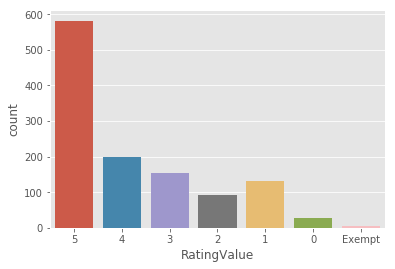

In [133]:
sns.countplot(x=bham_data_new.RatingValue, data=bham_data_new)

I wanted to see next if there is any visual relation between location and the rating of the establishments. Are there any clearly visibile clusters of establishments which share the same ratigs. This is what I explored next. I go on to create a list of folium map objects, each with a different rating. We then visualise them individually to see if there is any discernible pattern.

In [135]:
map_list = {}
markers = []
for index, rate in enumerate(bham_data_new.RatingValue.unique()):
    tempdf = bham_data_new[bham_data_new.RatingValue == rate].reset_index()
    map_list[str(rate)] = (folium.Map(location=[tempdf.loc[1, 'latitude'], tempdf.loc[1, 'longitude']], tiles='Stamen Terrain',zoom_start=11, min_zoom=11,max_zoom=13))  
    markers.append(MarkerCluster().add_to(map_list[str(rate)]))
    for point in range(0, tempdf.shape[0]):
        folium.Marker([tempdf.loc[point, 'latitude'] ,tempdf.loc[point, 'longitude']], popup=folium.Popup(tempdf.loc[point, 'BusinessName'], parse_html=True)).add_to(markers[index])


In [136]:
map_list['0']

In [137]:
map_list['1']

In [138]:
map_list['2']

In [139]:
map_list['3']

In [140]:
map_list['4']

In [141]:
map_list['5']

In [142]:
map_list['Exempt']

I achived something cool but not exactly what I set out to do. In some sense I found more than what I initially wanted as cafe&acute;s are only a subset of all restaurants and I can visualise them. Yet I am unable to filter down to the level of cafe&acute;s or only restaurants and visualise them separately. To some extent this was a limitation in the data since restaurants and caf&eacute;s are clubbed in one category. My initial na&iuml;ve assumption was that I could use some simple NLP to separate the two categories but that was not possible just from the names of the venues. So my next assumption was that perhaps I could use another api to find out cafe&acute;s and use it with this data to get the results I was hoping for. I had a quick look into yelp and found that not all places I had in my data were listen on yelp. So the quest still continues. For a start I could use yelp to grab data on the places that are on there and maybe fill the gaps using google. This will perhaps form another future post as that will be a small project on its own where I will have to employ different apis, nlp and other techniques I have not mapped out yet. I learned a lot in this project about things that I know and also about things that I did not know before. It is just one more step in my journey of learning!  


This has only been part 1 of my investigation into FHRS data. I will follow this up with some more insights into the data. I am a bit skeptical as to why there are only around ~1200 establishments returned for bham. I would suspect that number to be higher and have a rough idea of what might be goin on. Perhaps I will also look into the data for London, which has some of my favorite coffee spots! I also want to dive a bit more deeply into the capabilities of folium and look at the customisations and cool things which can be done with markers, groups and different tiles. 

If you read this post and find have any comments or suggestions please get in touch. I would love to hear from you and get some feedback. If you know of better ways or techniques than the ones I have used here for my analysis please let me know as I would definitley want to learn them! 